In [54]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
from scipy.interpolate import interp1d, RegularGridInterpolator
from astropy.cosmology import Planck13 as cosmo
import sys, time

# inline plotting
%matplotlib inline


# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sea
# seed the random number generator
np.random.seed(7)

from spec_exam import Gen_spec
from sim_engine import forward_model_grism, Salmon, F_lam_per_M
import fsps
from spec_id import *
from spec_tools import Oldest_galaxy, Photometry
from spec_stats import Highest_density_region

import dynesty
from dynesty import plotting as dyplot
from glob import glob

from dynesty.dynamicsampler import stopping_function, weight_function
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

from prospect.models.transforms import logsfr_ratios_to_masses
from multiprocessing import Pool
from scipy import stats
from scipy.special import erf, erfinv

import george
from george import kernels

In [61]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
# sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 1, tau=0.1, dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.255,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
            phot_errterm = 0.04, irac_err = 0.08, decontam = True) 

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [56]:
###############
###set prior###
###############
specz = 1.255
agelim = Oldest_galaxy(specz)

def all_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1

    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8], u[9], u[10],u[11]])
    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a))
    
    lm = Gaussian_prior(u[12], [9.5, 12.5], 11, 0.75)
  
    z = stats.norm.ppf(u[13],loc = specz, scale = 0.005)
    
    d = log_10_prior(u[14],[1E-3,2])
    
    bsc= Gaussian_prior(u[15], [0.8, 1.2], 1, 0.05)
    rsc= Gaussian_prior(u[16], [0.8, 1.2], 1, 0.05)
    bp1 = Gaussian_prior(u[17], [-0.1,0.1], 0, 0.05)
    rp1 = Gaussian_prior(u[18], [-0.05,0.05], 0, 0.025)
    
    ba = log_10_prior(u[19], [0.1,10])
    bb = log_10_prior(u[20], [0.0001,1])
    bl = log_10_prior(u[21], [0.01,1])
    
    ra = log_10_prior(u[22], [0.1,10])
    rb = log_10_prior(u[23], [0.0001,1])
    rl = log_10_prior(u[24], [0.01,1])
   
    lwa = get_lwa([m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a),sp)[0]
    
    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, bsc, rsc, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa]

def phot_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8], u[9], u[10],u[11]])

    lm = Gaussian_prior(u[12], [9.5, 12.5], 11, 0.75)
    
    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a))
    
    z = stats.norm.ppf(u[13],loc = specz, scale = 0.005)
    
    d = log_10_prior(u[14],[1E-5,2])
       
    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d]


def phot_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    
    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Pmfl = Gs.Sim_phot_mult(wave * (1 + z),F_lam_per_M(flux,wave*(1 + z), z,0,sp.stellar_mass)*10**lm)

    
    return -np.sum((( Gs.Pflx - Pmfl) / Gs.Perr )**2)/ 2

def all_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, bsc, rsc, bp1, rp1, ba, bb, bl, ra, rb, rl,  lwa = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    
    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr) 
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm, z)
       
    Gmfl = Full_calibrate(Gmfl, [bp1, rp1], [bsc, rsc])
   
    return Full_fit_2(Gs, Gmfl, Pmfl, [ba,ra], [bb,rb], [bl, rl])

In [57]:
def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl

def Full_calibrate(Gmfl, p1, sc):
    for i in range(len(wvs)):
        rGmfl= Gmfl[i] * (p1[i] * (wvs[i] -(wvs[i][-1] + wvs[i][0])/2 ) + 1E3)
        scale = Scale_model(Gmfl[i],np.ones_like(Gmfl[i]),rGmfl)
        Gmfl[i] = scale * rGmfl * sc[i]
    return Gmfl

def Calibrate_grism(spec, Gmfl, p1):
    linecal = []
    for i in range(len(wvs)):
        lines = (p1[i] * (wvs[i] -(wvs[i][-1] + wvs[i][0])/2 ) + 1E3)
        scale = Scale_model(flxs[i]  / lines, errs[i] / lines, Gmfl[i])    
        linecal.append(scale * lines)
        
    return linecal

def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs[i] / scale) - Gmfl[i]) / (errs[i] / scale))**2))
    
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2)) * -0.5

    return Gchi, Pchi

def Full_fit_2(spec, Gmfl, Pmfl,  a, b, l): 
    Gln = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        noise = noise_model(np.array([wvs[i],flxs[i], errs[i]]).T, Gmfl[i] * scale)
        noise.GP_exp_squared(a[i],b[i],l[i])
        Gln += noise.gp.lnlikelihood(noise.diff)

    Pln = lnlike_phot(spec.Pflx, spec.Perr, Pmfl)
    
    return Gln + Pln

In [62]:
dsampler = dynesty.NestedSampler(phot_L, phot_prior, ndim = 16, pool=Pool(processes=8), queue_size=8, sample = 'rwalk')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-fa

In [63]:
dsampler.run_nested(print_progress=True)

dres = dsampler.results

iter: 13106 | +500 | bound: 160 | nc: 1 | ncall: 310781 | eff(%):  4.378 | loglstar:   -inf < -21.716 <    inf | logz: -47.290 +/-  0.229 | dlogz:  0.001 >  0.509                                    

In [11]:
wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

In [12]:
asampler = dynesty.NestedSampler(all_L, all_prior, ndim = 26, pool=Pool(processes=8), queue_size=8, sample = 'rwalk')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Boundin

In [13]:
asampler.run_nested(print_progress=True)

ares = asampler.results

iter: 13800+500 | bound: 756 | nc: 1 | ncall: 322339 | eff(%):  4.436 | loglstar:   -inf < 1312.660 <    inf | logz: 1285.645 +/-  0.235 | dlogz:  0.001 >  0.509            /Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampler.py:220: RuntimeWarning: invalid value encountered in sqrt
  ('logzerr', np.sqrt(np.array(self.saved_logzvar))),


In [ ]:
26272, 41520, 29257, 42113,38843, 42778,39012, 43007,39364, 44042,40223

(<Figure size 864x3240 with 30 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a7f384710>,
       dtype=object))

<Figure size 1080x360 with 0 Axes>

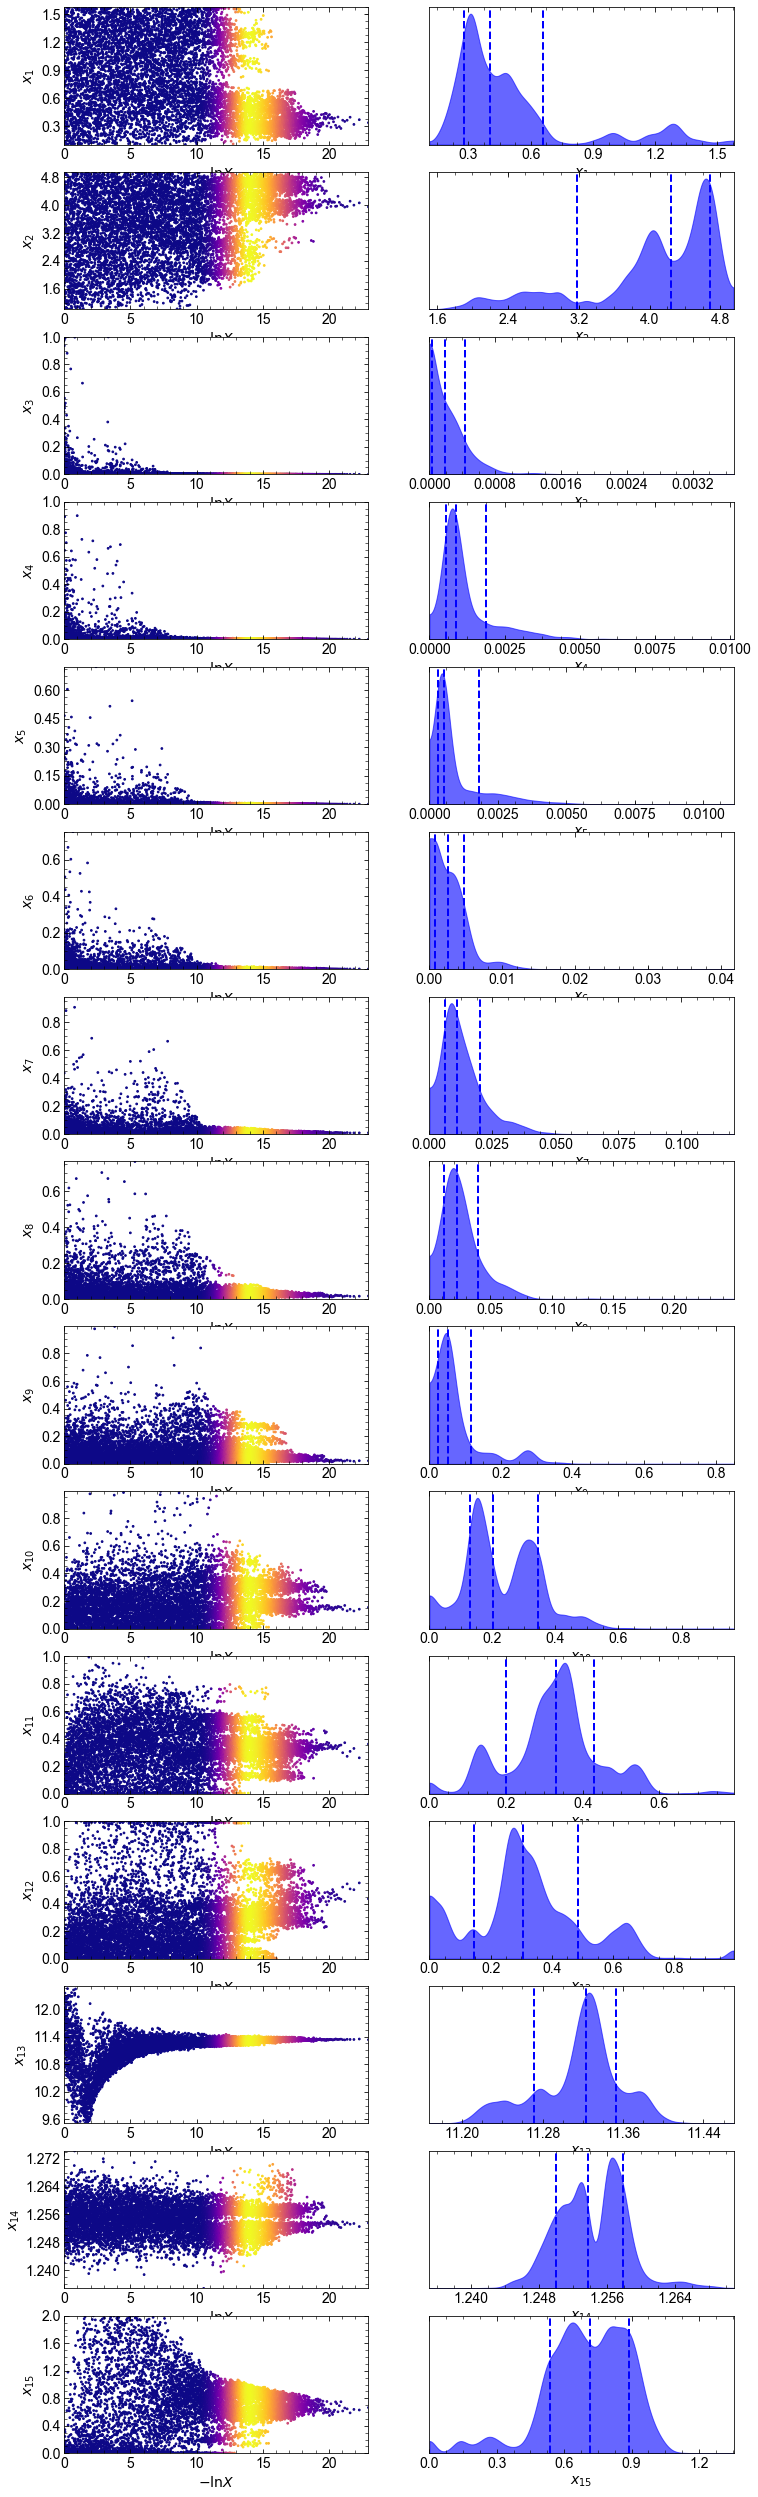

In [7]:
plt.figure(figsize=[15,5])
dyplot.traceplot(dres)

(<Figure size 864x3456 with 32 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a82438908>,
       dtype=object))

<Figure size 1080x360 with 0 Axes>

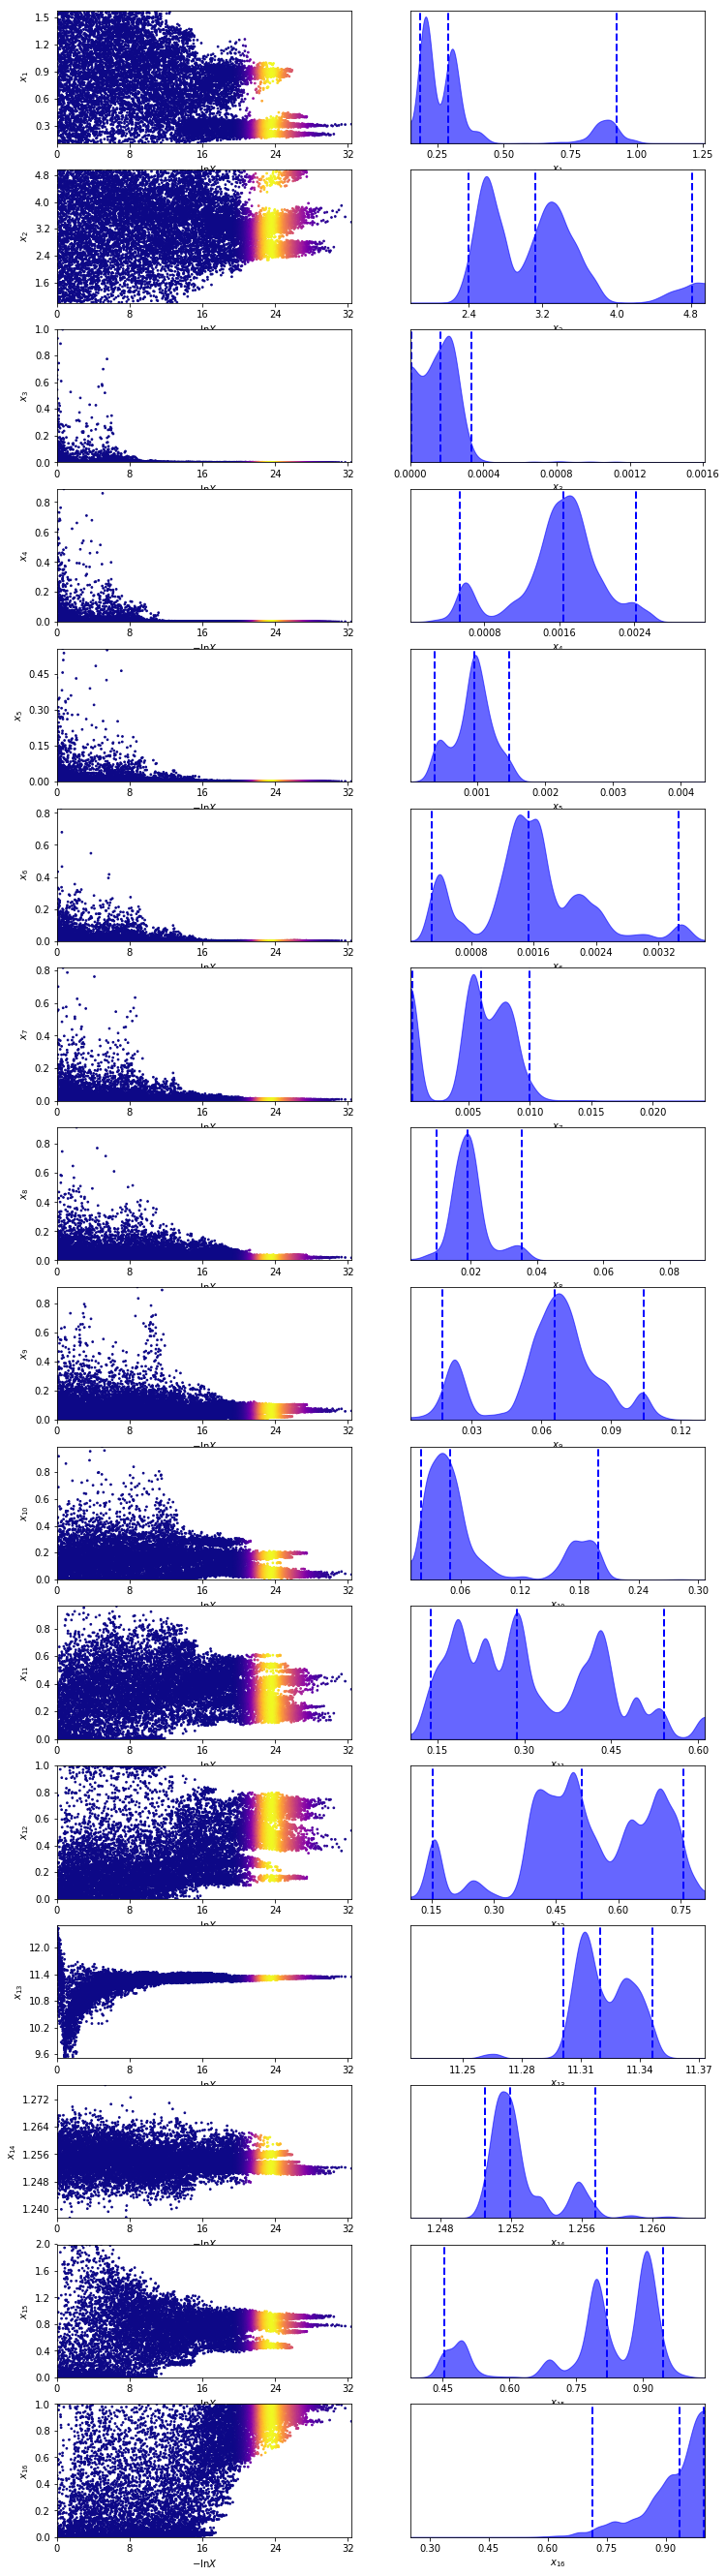

In [64]:
plt.figure(figsize=[15,5])
dyplot.traceplot(dres)

(<Figure size 864x5616 with 52 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a8244ddd8>,
       dtype=object))

<Figure size 1080x360 with 0 Axes>

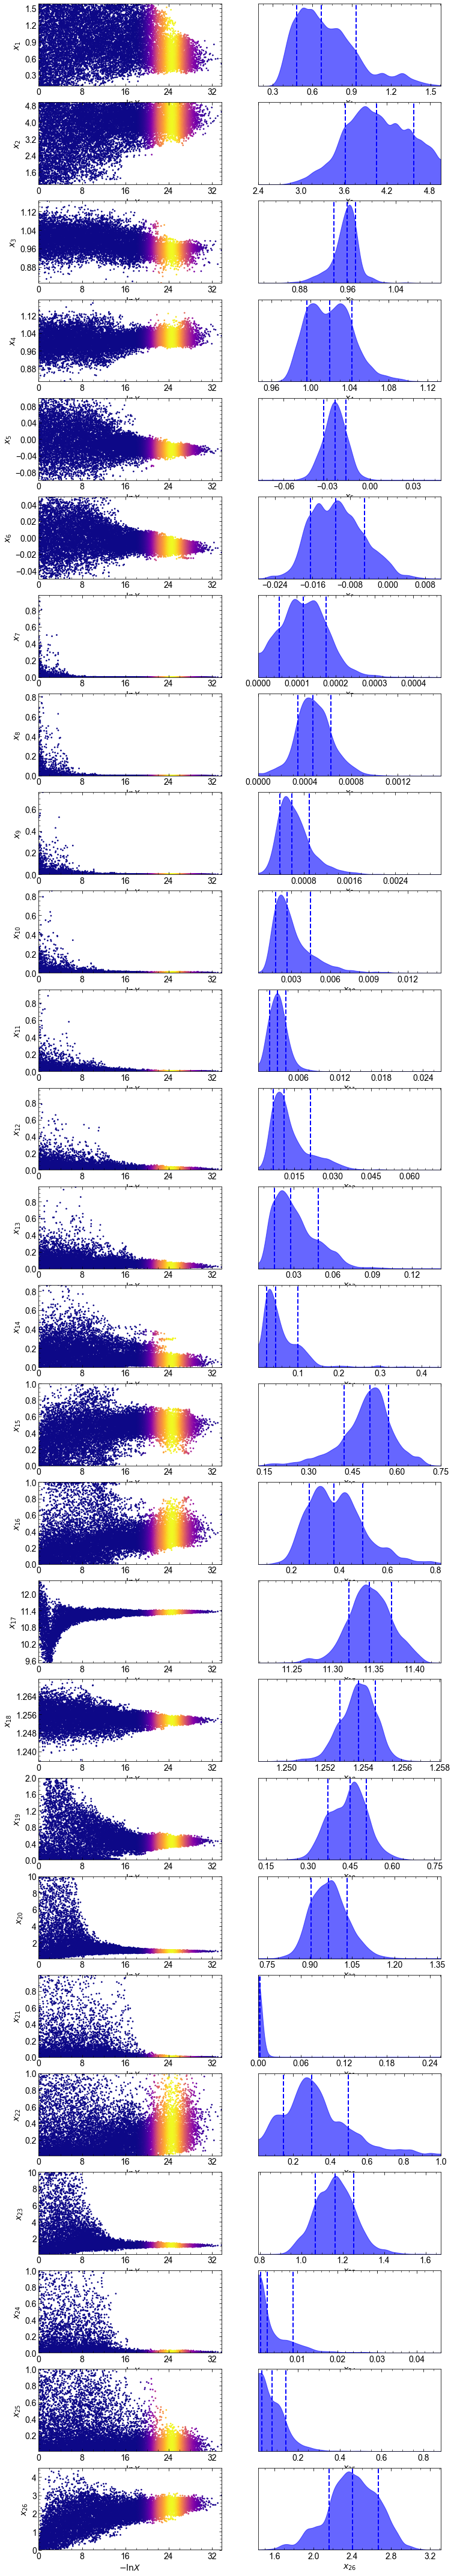

In [14]:


# plt.figure(figsize=[15,5])
# dyplot.traceplot(ares)

In [15]:
def Calibrate_grism(spec, Gmfl, p1):
    lines = (p1 * (spec[0] -(spec[0][-1] + spec[0][0])/2 ) + 1E3)
    scale = Scale_model(spec[1]  / lines, spec[2] / lines, Gmfl)    
    return scale * lines

In [16]:
m, a, bsc, rsc, bp1, rp1, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d ,ba,bb,bl,ra,rb,rl, lwa= ares.samples[-1]

sp.params['dust2'] = d
sp.params['dust1'] = d
sp.params['logzsol'] = np.log10(m)

time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

sp.set_tabular_sfh(time,sfr) 

wave, flux = sp.get_spectrum(tage = a, peraa = True)

Pmfl = Gs.Sim_phot_mult(wave * (1 + z),F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm)   

Bmfl = forward_model_all_beams(Gs.Bbeam, Gs.Btrans, Gs.Bwv, wave * (1 + z), 
                               F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm)
bscale = Calibrate_grism([Gs.Bwv,Gs.Bfl,Gs.Ber], Bmfl, bp1)
# Bchi = -np.sum((( Gs.Bfl - rscale * rGmfl * bsc) / Gs.Ber )**2 )/2

Rmfl = forward_model_all_beams(Gs.Rbeam, Gs.Rtrans, Gs.Rwv, wave * (1 + z), 
                               F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm)
rscale = Calibrate_grism([Gs.Rwv,Gs.Rfl,Gs.Rer], Rmfl, rp1)

# Rchi =  -np.sum((( Gs.Rfl - rscale * rGmfl * rsc) / Gs.Rer )**2 )/2 

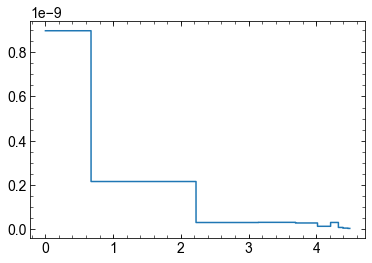

In [17]:
plt.plot(time, sfr)

([<matplotlib.axis.XTick at 0x1a866d0d30>,
 <a list of 5 Text xticklabel objects>)

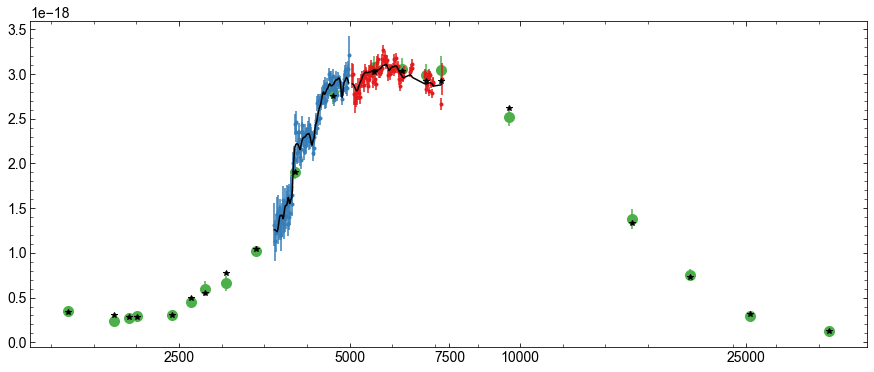

In [18]:
plt.figure(figsize = [15,6])

plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl / (bscale),Gs.Ber / (bscale),
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl / (rscale),Gs.Rer / (rscale),
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
plt.plot(np.log10(Gs.Bwv_rf), Bmfl, 'k', zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Rmfl, 'k', zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Pmfl, 'k*' , zorder=5)

plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

logage = 9.06
logtau = 8.10
Av = 0.16
Z = 0.02
lmass = 11.10

In [33]:
10**8.1 / 10**9, 10**9.06 / 10**9

(0.12589254117941662, 1.1481536214968842)

In [5]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=1, zcontinuous = 1, logzsol = 0, sfh = 1, tau=0.126, dust_type = 1)
sp.params['dust2'] = 0.16
sp.params['dust1'] = 0.16

wave, flux = sp.get_spectrum(tage = 1.148, peraa = True)

sflux2 = F_lam_per_M(flux,wave*(1+1),1,0,sp.stellar_mass)*10**11.1

(3.0969100130080562, 4.6020599913279625)

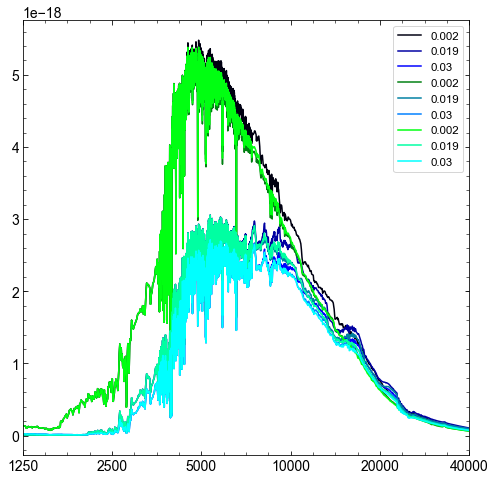

In [37]:
plt.figure(figsize = [8,8])

metals = [0.002, 0.019, 0.03]
for i in range(3):
    sp = fsps.StellarPopulation(tpagb_norm_type=int(i), zcontinuous = 1, logzsol = 0, sfh = 1, tau=0.126, dust_type = 1)
    sp.params['dust2'] = 0.16
    sp.params['dust1'] = 0.16
    for m in metals:
        sp.params['logzsol'] = np.log10(m / 0.019)
        wave, flux = sp.get_spectrum(tage = 4, peraa = True)
        sflux2 = F_lam_per_M(flux,wave*(1+1),1,0,sp.stellar_mass)*10**11.1

        plt.plot(np.log10(wave), sflux2,color = [0,i/2,m/0.03], label = m)
plt.legend()
plt.xticks(np.log10([1250,2500,5000,10000,20000,40000]),[1250,2500,5000,10000,20000,40000])
plt.xlim(np.log10(1250),np.log10(40000))

(3.0969100130080562, 4.6020599913279625)

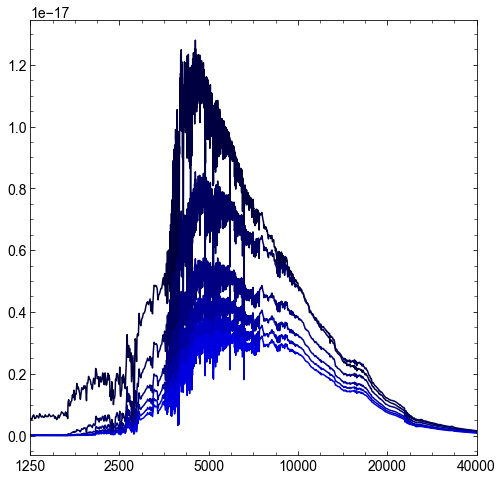

In [17]:
sp = fsps.StellarPopulation(imf_type = 2, zcontinuous = 1, logzsol = 0, sfh = 1, tau=0.126, dust_type = 1)
sp.params['dust2'] = 0.16
sp.params['dust1'] = 0.16

plt.figure(figsize = [8,8])
for a in np.arange(1,4,0.5):
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    sflux2 = F_lam_per_M(flux,wave*(1+1),1,0,sp.stellar_mass)*10**11.1

    plt.plot(np.log10(wave), sflux2,color = [0,0,a/4])
plt.xticks(np.log10([1250,2500,5000,10000,20000,40000]),[1250,2500,5000,10000,20000,40000])
plt.xlim(np.log10(1250),np.log10(40000))

In [50]:
rBmfl = Bmfl*((.1 *Gs.Bwv) )
rscale = Scale_model(Bmfl,np.ones_like(Bmfl),rBmfl)

rBmfl1 = Bmfl*((.1 * (Gs.Bwv - Gs.Bwv[0])))
rscale1 = Scale_model(Bmfl,np.ones_like(Bmfl),rBmfl1)

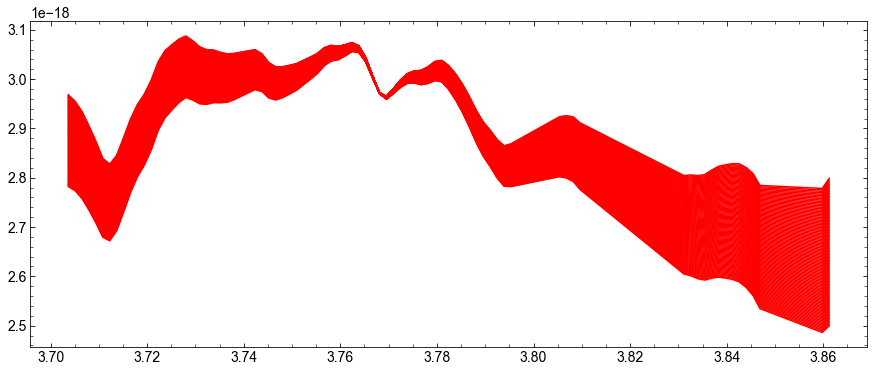

In [104]:
plt.figure(figsize = [15,6])

for i in np.arange(-500,500,10):
    rRmfl = Rmfl*(i * (Gs.Rwv -(Gs.Rwv[-1] + Gs.Rwv[0])/2 ) /(Gs.Rwv[-1] + Gs.Rwv[0]) + 1E3)
    rscale = Scale_model(PC*Rmfl,np.ones_like(Rmfl),rRmfl)
    plt.plot(np.log10(Gs.Rwv_rf), rRmfl * rscale , 'r', zorder=5)
#     plt.plot(np.log10(Gs.Rwv_rf), (i * (Gs.Rwv -(Gs.Rwv[-1] + Gs.Rwv[0])/2 ) /(Gs.Rwv[-1] + Gs.Rwv[0]) + 1E3), 'r', zorder=5)
    
# plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl, 'k', zorder=5)


<ErrorbarContainer object of 3 artists>

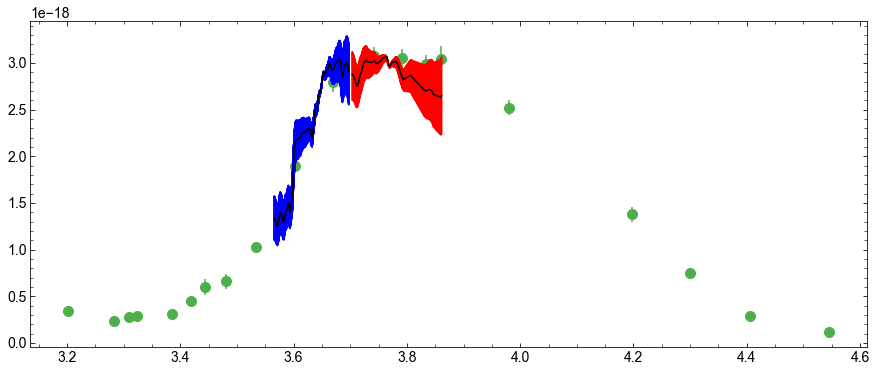

In [110]:
plt.figure(figsize = [15,6])

for i in np.arange(-0.05,0.05,0.001):
    rRmfl = Rmfl*(i * (Gs.Rwv -(Gs.Rwv[-1] + Gs.Rwv[0])/2 ) + 1E3)
    rscale = Scale_model(PC*Rmfl,np.ones_like(Rmfl),rRmfl)
    plt.plot(np.log10(Gs.Rwv_rf), rRmfl * rscale , 'r', zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl, 'k', zorder=5)

for i in np.arange(-0.1,0.1,0.001):
    rBmfl = Bmfl*(i * (Gs.Bwv -(Gs.Bwv[-1] + Gs.Bwv[0])/2 ) + 1E3)
    rscale = Scale_model(PC*Bmfl,np.ones_like(Bmfl),rBmfl)

    plt.plot(np.log10(Gs.Bwv_rf), rBmfl * rscale , 'B', zorder=5)
plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl, 'k', zorder=5)

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')

In [45]:
np.mean(Gs.Bfl) / 10

2.6487085136879153e-19